# Elasto-inertial Turbulence

In this notebook, the Callaham et al. paper's method is used on simulation data of a polymer-laden flow, where the governing equation is much more complex, and some dominant balance regimes may be unknown still, unlike for well-studied cases in the paper (e.g. Turbulent Boundary Layer, Geostrophic Balance,...)

The governing equation is here given by:

$$ \partial_{t}\mathbf{u} + (\mathbf{u} \cdot \mathbf{\nabla})\mathbf{u} + \mathbf{\nabla}p = \frac{\beta}{Re} \Delta \mathbf{u} + \frac{1 - \beta}{Re} \mathbf{\nabla} \cdot \mathbf{T}(\mathbf{C}) $$

where

$ \mathbf{T}(\mathbf{C}) := \frac{1}{Wi}(f(\text{tr}\mathbf{C})\mathbf{C} - \mathbf{I}) $, and $ f(x) := (1 - \frac{x - 3}{L_{max}^{2}})^{-1} $.



Thus, $\mathbf{T}(\mathbf{C}) = \frac{1}{Wi} ((1 - \frac{(\text{tr}\mathbf{C}) - 3}{L_{max}^{2}})^{-1}\mathbf{C} - \mathbf{I}) $



In [102]:
import h5py
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib as mpl
from matplotlib.colors import ListedColormap

# adding Tools to the system path, and importing the modules
sys.path.insert(0, "../Tools/")
import plot_funcs as pf
import stability_assessment as sa

# Set the plotting style
mpl.rc("text", usetex=True)
mpl.rc("font", family="serif")
mpl.rc("figure", figsize=(15, 3))
mpl.rc("xtick", labelsize=14)
mpl.rc("ytick", labelsize=14)
mpl.rc("axes", labelsize=20)
mpl.rc("axes", titlesize=20)

# Set the colormap
cm = sns.color_palette("tab10").as_hex()
cm.insert(0, "#ffffff")
cm = ListedColormap(cm)
cm.set_bad("darkgrey")

In [103]:
# Create plot directory
cur_dir = os.getcwd()
proj_dir = os.path.dirname(cur_dir)
plots_dir = os.path.join(proj_dir, "Plots/EIT")
os.makedirs(plots_dir, exist_ok=True)

## 1. Load the data

That dataset here contains simulation data for one of the attractors discussed in the [Beneitez et al. (2024)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/multistability-of-elastoinertial-twodimensional-channel-flow/D63B7EDB638451A6FC2FBBFDA85E1BBD) paper. The attractor in question is the Chaotic Arrowhead Regime (CAR), which is characterised by a weak arrowhead structure near the centre of the channel. With EIT, it shares being maintained through near-wall mechanisms of energy transfers.

In [104]:
# Load the data
path = "../Data/39_60_512_512_CAR_Fdp.h5"
data = h5py.File(path, "r")

print(data.keys())

<KeysViewHDF5 ['Fdp', 'c11', 'c12', 'c22', 'c33', 'p', 'time', 'u', 'v']>


In this dataset are:
- Fdp, which is mean pressure gradient term at each snapshot to satisfy the constant mass flux
- The 4 components of the Conformation Tensor C; $\mathbf{C}_{xx}, \mathbf{C}_{yy}, \mathbf{C}_{zz}, \mathbf{C}_{xy}$.
- The time for which the snapshot corresponds to, t.
- (u, v), the streamwise and wall-normal velocity components
- p (in actuality p'), the fluctuation from the mean pressure term. 

They have the following size:
[Seed/Trajectory number, Snapshot number, Nx, Ny], except for time which is just [Seed/Trajectory number, Snapshot number]

There is a few dimensionless parameters that must be set, and these have values set for the data simulation (for CAR statistically steady state):

- $Re = 1000$, the Reynolds number
- $Wi = 50$, the Weissenberg number
- $beta = 0.9$, denotes the viscosity ratio of solvent/polymer contributions to the total kinematic viscosity
- $L_{max} = 70$, the maximum extensibility of the polymer chains
- $[L_{x}, L_{y}] = [2, 2 \pi]$, the domain extents, in units of h (the half-distance between the plates)


In [105]:
# Set the values of some parameters
Re = 1000
Wi = 50
beta = 0.9
Lmax = 70
Lx = 2 * np.pi
Ly = 2

## 2. Get the equation space representation of the data

First, the x-component of the governing equation is studied. This is given as:

$$ \partial_{t}u + u u_{x} + v u_{y} + p_{x} = \frac{\beta}{Re} (u_{xx} + u_{yy}) + \frac{1 - \beta}{Re} ( (\frac{1}{Wi} ((1 - \frac{(\text{tr}\mathbf{C}) - 3}{L_{max}^{2}})^{-1} C_{xx} - 1))_{x} + (\frac{1}{Wi} ((1 - \frac{(\text{tr}\mathbf{C}) - 3}{L_{max}^{2}})^{-1} C_{xy}))_{y} ) $$




Thus the variables needed are:
- $u, \partial u/\partial x, \partial^{2} u/ \partial x^{2}, \partial u/\partial y, \partial^{2} u/ \partial y^{2}, \partial p/\partial x$, and the x-derivative and y-derivative of those last two RHS terms

In this dataset are 39 trajectories, with 60 snapshots each. Trajectories are time evolutions of an initial condition, and snapshots are different instances of the flow taken at regular intervals. Particularly, the last snapshot of each trajectory is then followed in time by the first snapshot of the next trajectory. In other words, putting all trajectories one after the other would give the "full" time series evolution of the flow.

In [106]:
# Choose the snapshot and trajectory
traj_seed = 5
snapshot = 15

In [107]:
# Extract the data fields
u = data["u"][
    traj_seed, snapshot - 1 : snapshot + 2, :, :
]  # Extract the velocity field,
# taking the previous and following
# snapshots as well for time derivatives
v = data["v"][traj_seed, snapshot, :, :]  # Wall-normal velocity
p = data["p"][traj_seed, snapshot, :, :]  # Pressure field
Fdp = data["Fdp"][traj_seed, snapshot, :, :]  # Time varying pressure gradient
Cxx = data["c11"][
    traj_seed, snapshot, :, :
]  # First diagonal component of the conformation tensor
Cxy = data["c12"][
    traj_seed, snapshot, :, :
]  # Non-diagonal components of the conformation tensor
Cyy = data["c22"][
    traj_seed, snapshot, :, :
]  # Second diagonal component of the conformation tensor
t_prev = data["time"][traj_seed, snapshot - 1]  # Time of the previous snapshot
t = data["time"][traj_seed, snapshot]  # Time of the current snapshot
t_next = data["time"][traj_seed, snapshot + 1]  # Time of the following snapshot

trC = Cxx + Cyy

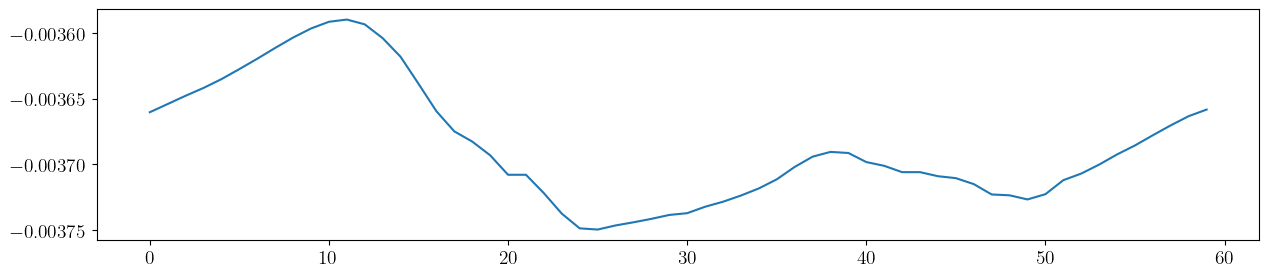

In [108]:
# Plot the time varying pressure gradient
Fdp_list = data["Fdp"][1, :, 0, 0].flatten()
plt.plot(Fdp_list)

In [109]:
# Get the derivatives

# Get the time derivative as 2nd order central difference
dt = t_next - t_prev
u_t = (u[2] - u[0]) / (2 * dt)

# Get the spatial derivatives, using numpy's gradient function
nx = u.shape[2]
ny = u.shape[1]

u_y, u_x = np.gradient(u[1], Ly / ny, Lx / nx)

# The pressure gradient is defined as the sum of the mean pressure gradient at the current time step
# and the x-derivative of the fluctuating pressure termm
p_fluc_x = np.gradient(p, Lx / nx, axis=1, edge_order=2)
p_x = Fdp + p_fluc_x


u_xx = np.gradient(u_x, Lx / nx, axis=1, edge_order=2)
u_yy = np.gradient(u_y, Ly / ny, axis=0, edge_order=2)

$$ \partial_{t}u + u u_{x} + v u_{y} + p_{x} = \frac{\beta}{Re} (u_{xx} + u_{yy}) + \frac{1 - \beta}{Re} ( (\frac{1}{Wi} ((1 - \frac{(\text{tr}\mathbf{C}) - 3}{L_{max}^{2}})^{-1} C_{xx} - 1))_{x} + (\frac{1}{Wi} ((1 - \frac{(\text{tr}\mathbf{C}) - 3}{L_{max}^{2}})^{-1} C_{xy}))_{y} ) $$

In [110]:
# Define the RHS terms, separating them in 3 parts.

# The first part is the laplacian of the velocity field
RHS1 = (beta / Re) * (u_xx + u_yy)

# Then are the terms describing the x-component of the divergence of the
# polymer stress tensor: T(C)
RHS2 = (1 / Wi) * ((1 / (1 - (trC - 3) / (Lmax**2))) * Cxx - 1)
RHS3 = (1 / Wi) * ((1 / (1 - (trC - 3) / (Lmax**2))) * Cxy)

RHS2 = ((1 - beta) / Re) * np.gradient(RHS2, Lx / nx, axis=1, edge_order=2)
RHS3 = ((1 - beta) / Re) * np.gradient(RHS3, Ly / ny, axis=0, edge_order=2)

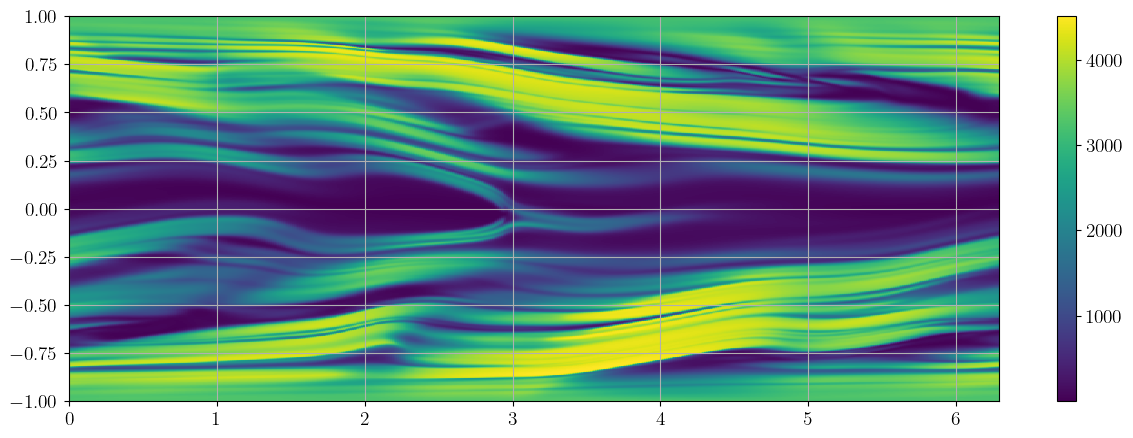

In [111]:
# Plot one of the conformation tensor's components to visualise the structure of the CAR
fig = plt.figure(figsize=(15, 5))

X, Y = np.meshgrid(np.linspace(0, Lx, nx), np.linspace(-Ly / 2, Ly / 2, ny))


plt.pcolormesh(X, Y, Cxx, cmap="viridis")
plt.colorbar()
plt.grid()

In [112]:
# Define the equation term
equation = u_t + (u[1] * u_x) + (v * u_y) + p_fluc_x - RHS1 - RHS2 - RHS3
equation_Fdp = u_t + (u[1] * u_x) + (v * u_y) + p_x - RHS1 - RHS2 - RHS3

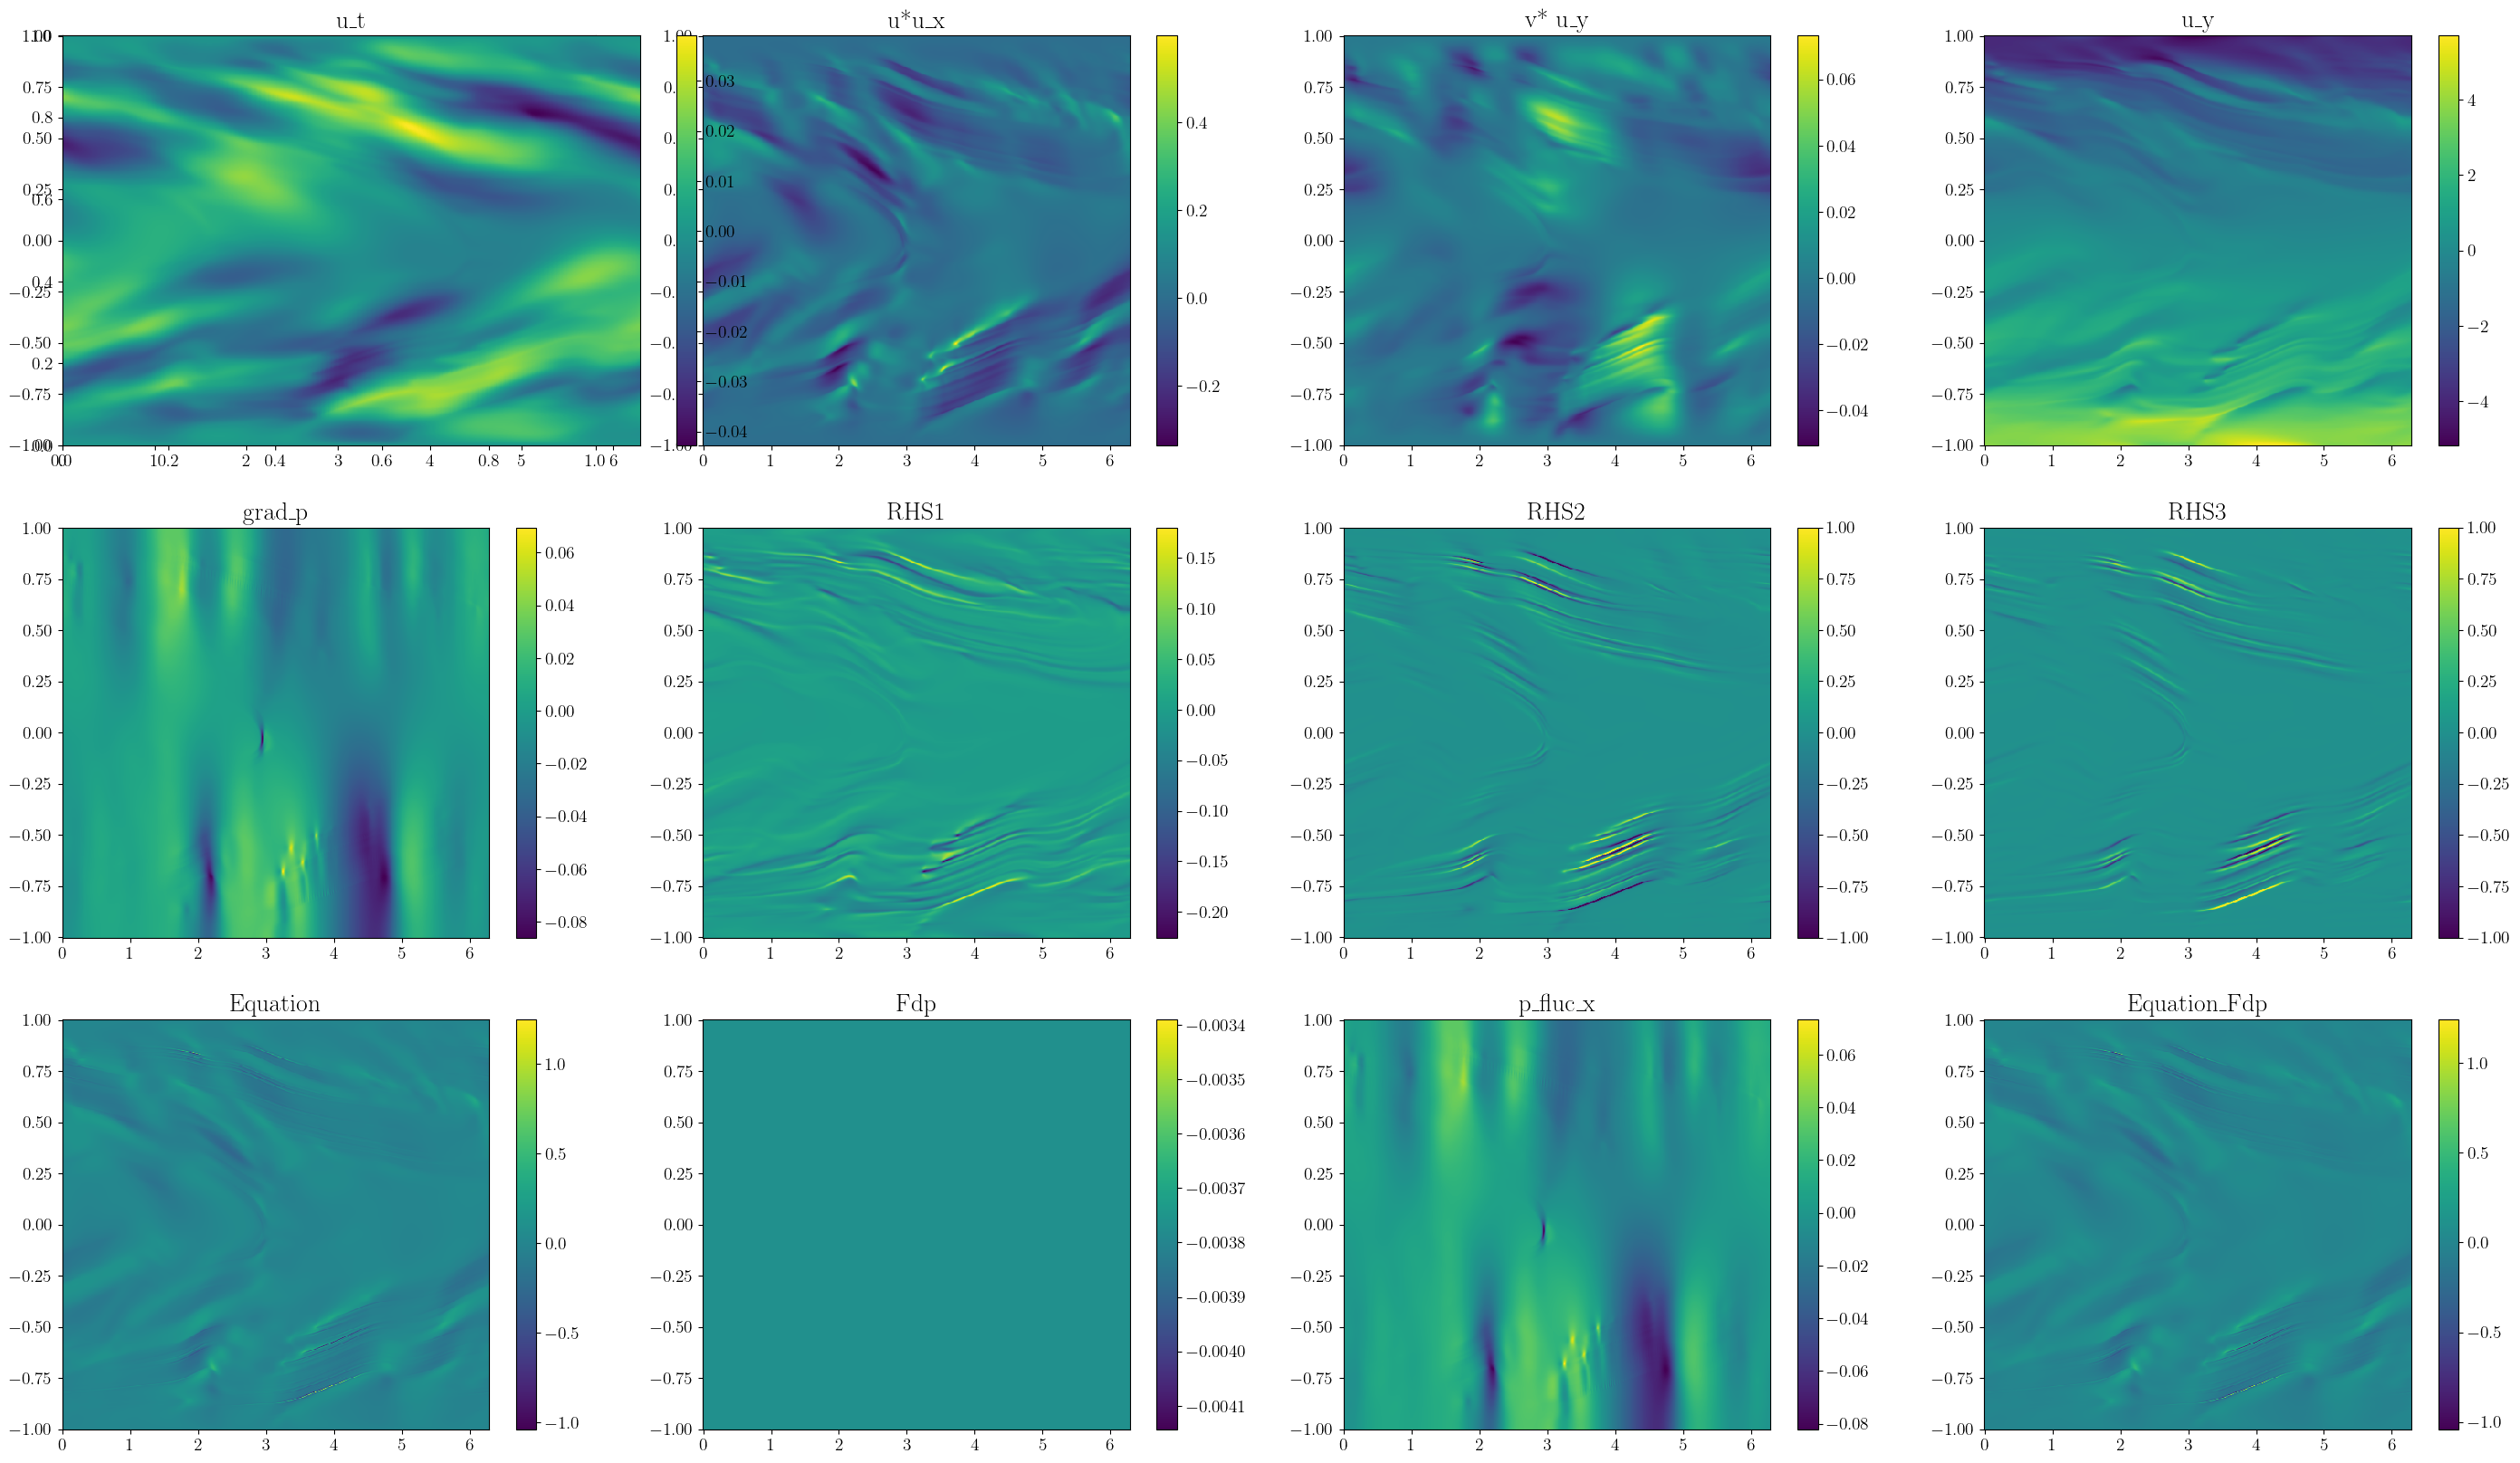

In [113]:
# Plot fields of all the terms in the governing equation
fig = plt.subplots(3, 4, figsize=(35, 20))

plt.subplot(3, 3, 1)
plt.pcolormesh(X, Y, u_t, cmap="viridis")
plt.title("u_t")
plt.colorbar()

plt.subplot(3, 4, 2)
plt.pcolormesh(X, Y, u[1] * u_x, cmap="viridis")
plt.title("u*u_x")
plt.colorbar()

plt.subplot(3, 4, 3)
plt.pcolormesh(X, Y, v * u_y, cmap="viridis")
plt.title("v* u_y")
plt.colorbar()

plt.subplot(3, 4, 4)
plt.pcolormesh(X, Y, u_y, cmap="viridis")
plt.title("u_y")
plt.colorbar()


plt.subplot(3, 4, 5)
plt.pcolormesh(X, Y, p_x, cmap="viridis")
plt.title("grad_p")
plt.colorbar()

plt.subplot(3, 4, 6)
plt.pcolormesh(X, Y, RHS1, cmap="viridis")
plt.title("RHS1")
plt.colorbar()

plt.subplot(3, 4, 7)
plt.pcolormesh(X, Y, RHS2, cmap="viridis", vmax=1, vmin=-1)
plt.title("RHS2")
plt.colorbar()

plt.subplot(3, 4, 8)
plt.pcolormesh(X, Y, RHS3, cmap="viridis", vmax=1, vmin=-1)
plt.title("RHS3")
plt.colorbar()

plt.subplot(3, 4, 9)
plt.pcolormesh(X, Y, equation, cmap="viridis")
plt.title("Equation")
plt.colorbar()

plt.subplot(3, 4, 10)
plt.pcolormesh(X, Y, Fdp, cmap="viridis")
plt.title("Fdp")
plt.colorbar()

plt.subplot(3, 4, 11)
plt.pcolormesh(X, Y, p_fluc_x, cmap="viridis")
plt.title("p_fluc_x")
plt.colorbar()

plt.subplot(3, 4, 12)
plt.pcolormesh(X, Y, equation_Fdp, cmap="viridis")
plt.title("Equation_Fdp")
plt.colorbar()

In [114]:
# Define the features:

features = pd.DataFrame(
    {
        "u_t": u_t.flatten(),
        "uu_x": (u[0] * u_x).flatten(),
        "vu_y": (v * u_y).flatten(),
        "p_x": (p_x).flatten(),
        "nondim_Lap_u": (RHS1).flatten(),
        "tensor1": RHS2.flatten(),
        "tensor2": RHS3.flatten(),
    }
)

features = features.to_numpy()
nfeatures = features.shape[1]

In [115]:
labels = [
    r"$u_{t}$",
    r"$u u_{x}$",
    r"$v u_{y}$",
    r"$p_{x}$",
    r"$\nabla^2 u$",
    r"$[T(C)]_{1}$",
    r"$[T(C)]_{2}$",
]

## 3. Cluster using GMM

### 3.1. TO choose how many clusters:

To find a good number of clusters, one can look at the covariance matrices of the clusters as the number of clusters increases. Once adding clusters only adds more duplicates, this will indicate that a sufficient number of clusters has been set.

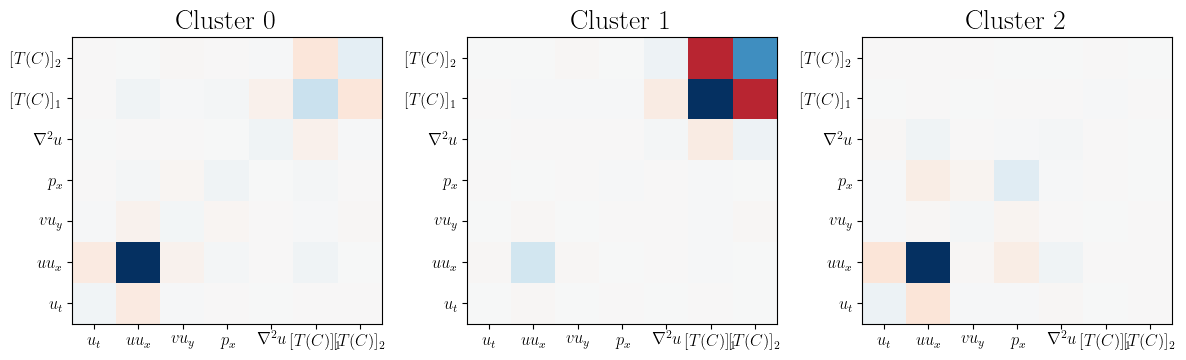

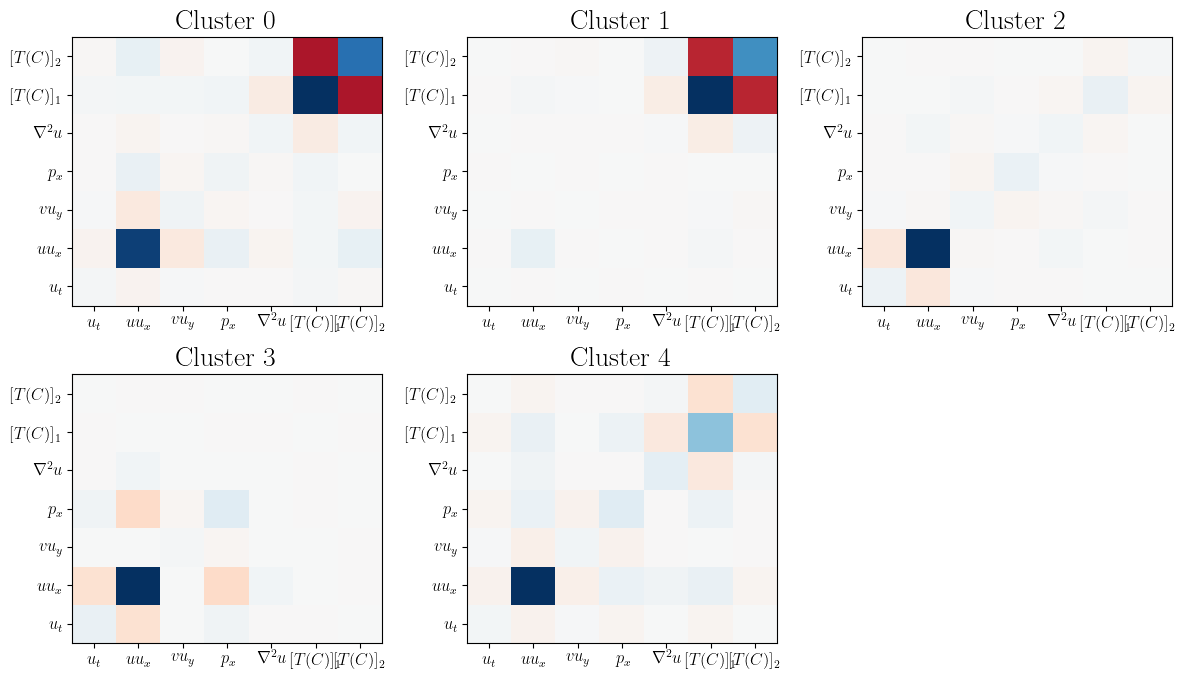

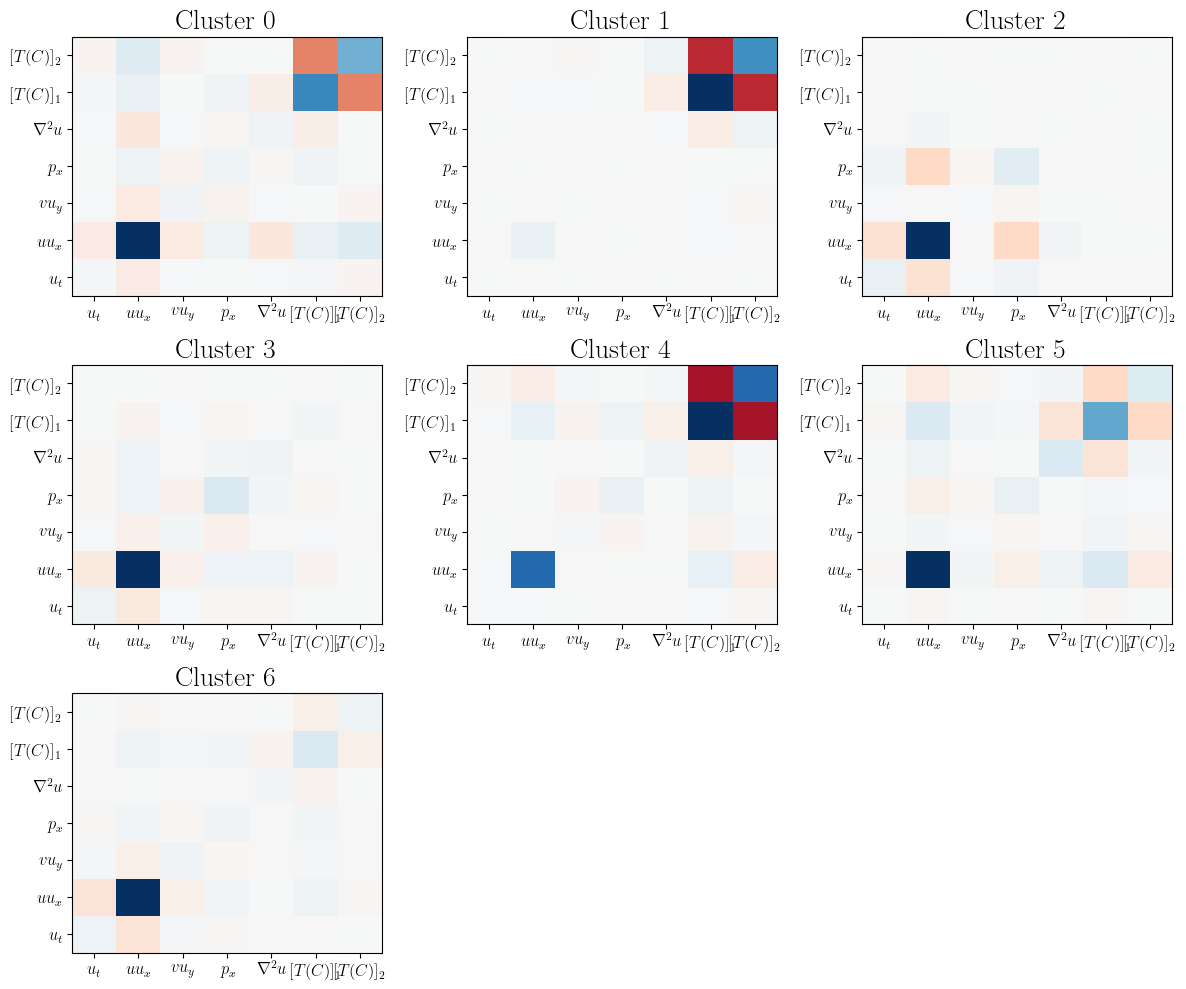

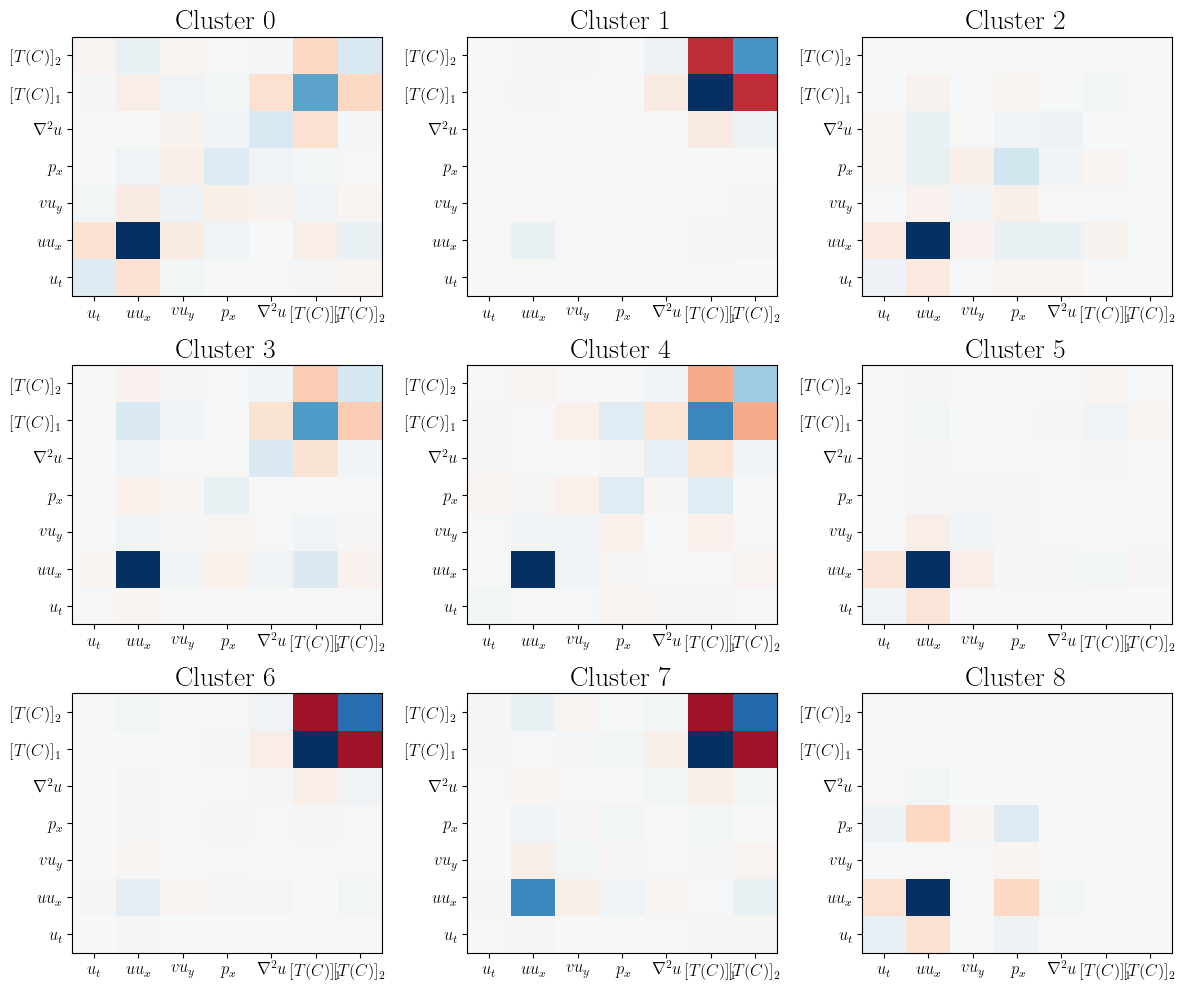

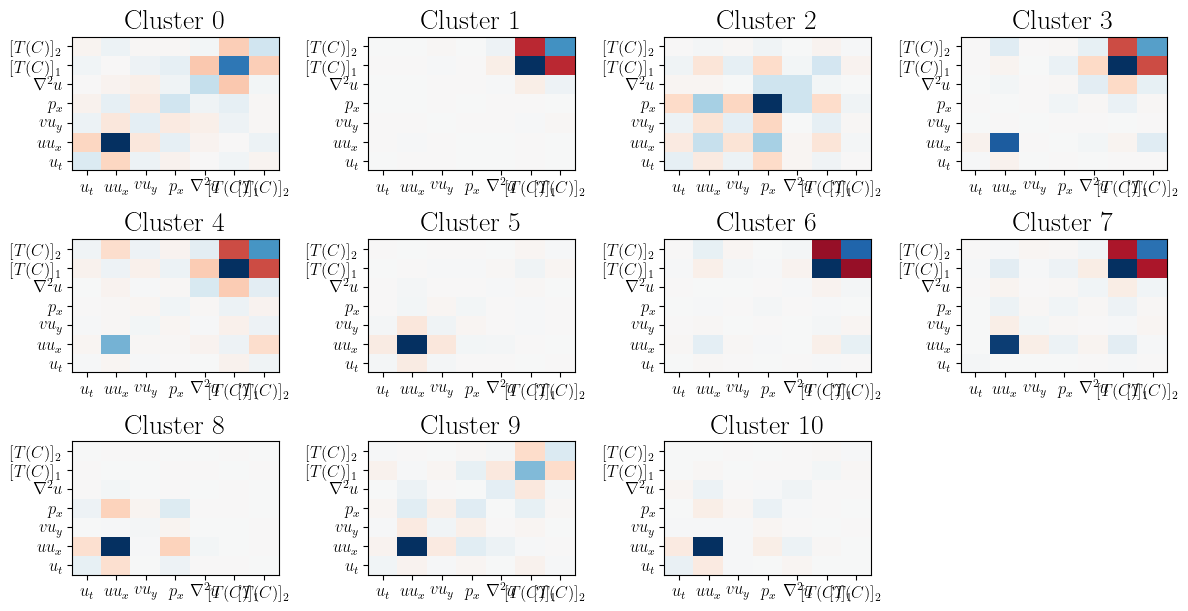

In [116]:
# Set the random seeds
seed = 75016
np.random.seed(seed)

# Get a subset of the data
frac = 0.3
features_training = train_test_split(features, train_size=frac, random_state=seed)[0]

# Set number of clusters
n_clusters = [3, 5, 7, 9, 11]

for idx, nc in enumerate(n_clusters):
    # Define the model
    GMM = GaussianMixture(n_components=nc, random_state=seed)
    # GMM = CustomGMM(n_components=n_clusters, n_features = 7, random_state=seed)

    # Fit the model
    GMM.fit(features_training)

    # Plot the covariance matrices of each cluster

    pf.plot_cov_mat(
        GMM,
        features.shape[1],
        nc,
        labels,
        "GMM",
        path=f"EIT/GMM_cov_mat_{nc}.png",
    )

Thus, a valid cluster number choice could be 8. 

In [117]:
# Set the random seeds
seed = 75016
np.random.seed(seed)

# Get a subset of the data
frac = 0.3
features_training = train_test_split(features, train_size=frac, random_state=seed)[0]

# Set number of clusters
n_clusters = 8

# Define the model
GMM = GaussianMixture(n_components=n_clusters, random_state=seed)
# GMM = CustomGMM(n_components=n_clusters, n_features = 7, random_state=seed)

# Fit the model
GMM.fit(features_training)

GaussianMixture(n_components=8, random_state=75016)

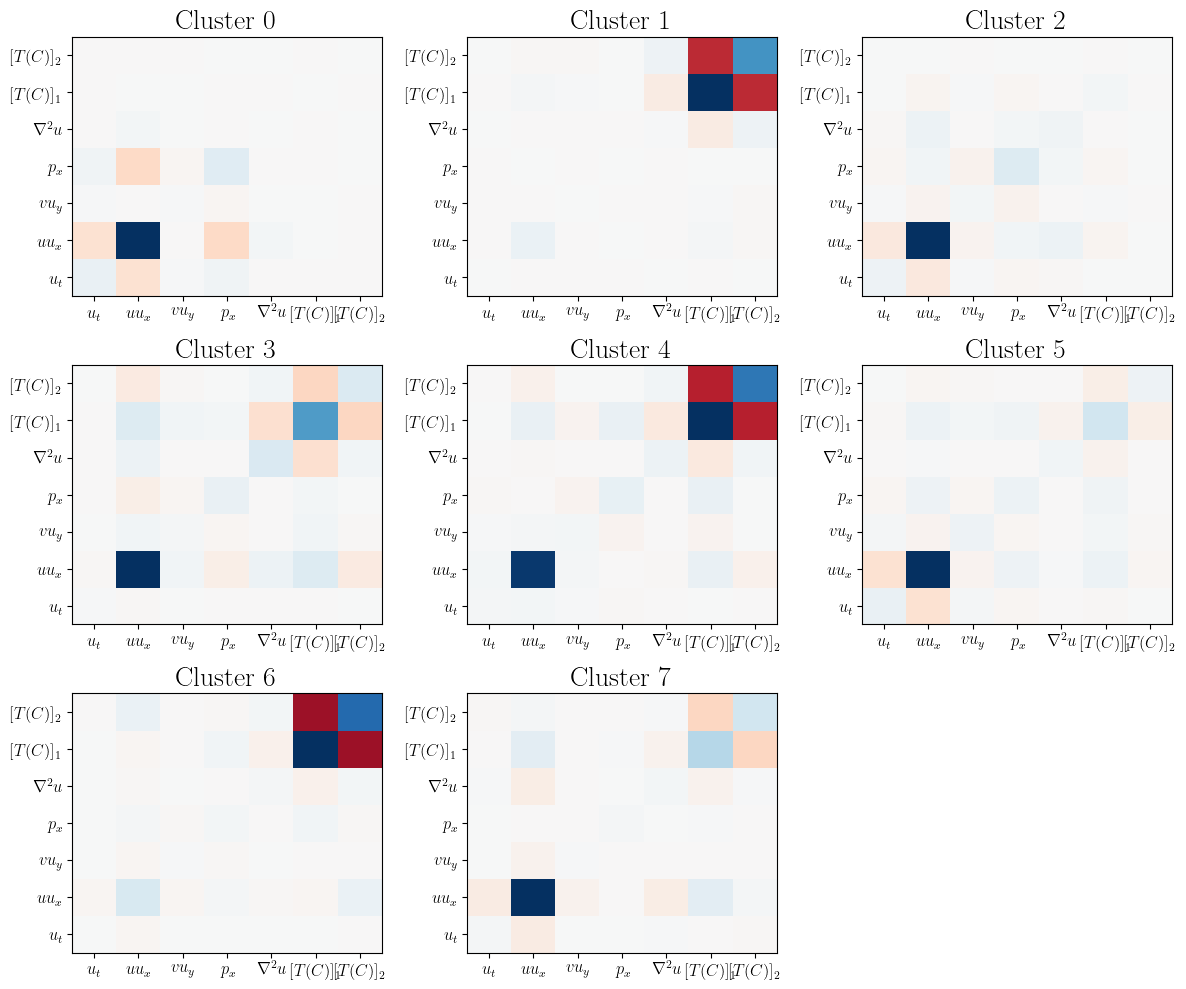

In [118]:
# Plot the covariance matrices of each cluster

pf.plot_cov_mat(
    GMM,
    features.shape[1],
    n_clusters,
    labels,
    "GMM",
    path=f"EIT/GMM_cov_mat_{n_clusters}.png",
)

In [119]:
# Predict the clusters for the entire dataset
cluster_idx = GMM.predict(features)

# FOR UNCERTAINTIES
# Get the cluster membership probabilities
cluster_probs = GMM.predict_proba(features)

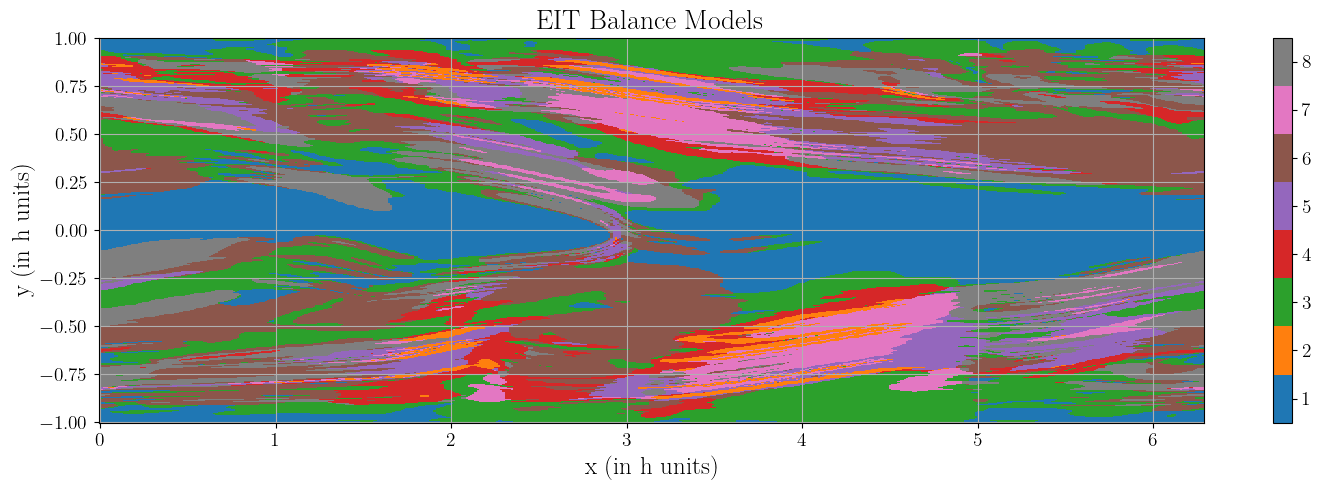

In [120]:
# Plot the clusters in space
clustermap = cluster_idx.reshape((ny, nx))
pf.plot_clusters_eit(
    clustermap, Lx, nx, Ly, ny, n_clusters, path="EIT/GMM_clusters_{n_clusters}.png"
)

## 4. Apply SPCA

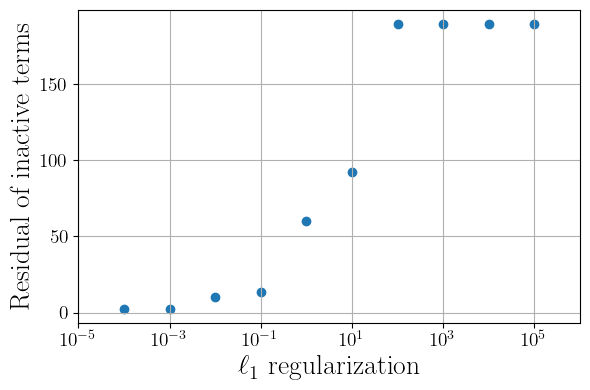

In [121]:
alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])


def spca_err(alpha, cluster_idx, features, nc):
    err_ = 0

    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.where(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alpha, random_state=seed)
        spca.fit(cluster_features)

        # Identify active and inactive terms
        active_terms = np.where(spca.components_[0] != 0)[0]
        inactive_terms = np.where(spca.components_[0] == 0)[0]

        err_ += np.sqrt(np.sum((cluster_features[:, inactive_terms].ravel()) ** 2))

    return err_


from joblib import Parallel, delayed

err = Parallel(n_jobs=4)(
    delayed(spca_err)(alpha, cluster_idx, features, n_clusters) for alpha in alphas
)

pf.plot_spca_residuals(alphas, err, path=f"EIT/SPCA_residuals_{n_clusters}.png")

### 4.1. To choose the value for $\alpha$


To choose the value for $\alpha$, the method used in the Stability Assessment Notebook (```./Stability_Assessment.ipynb```) is repeated here, simply evaluating the 

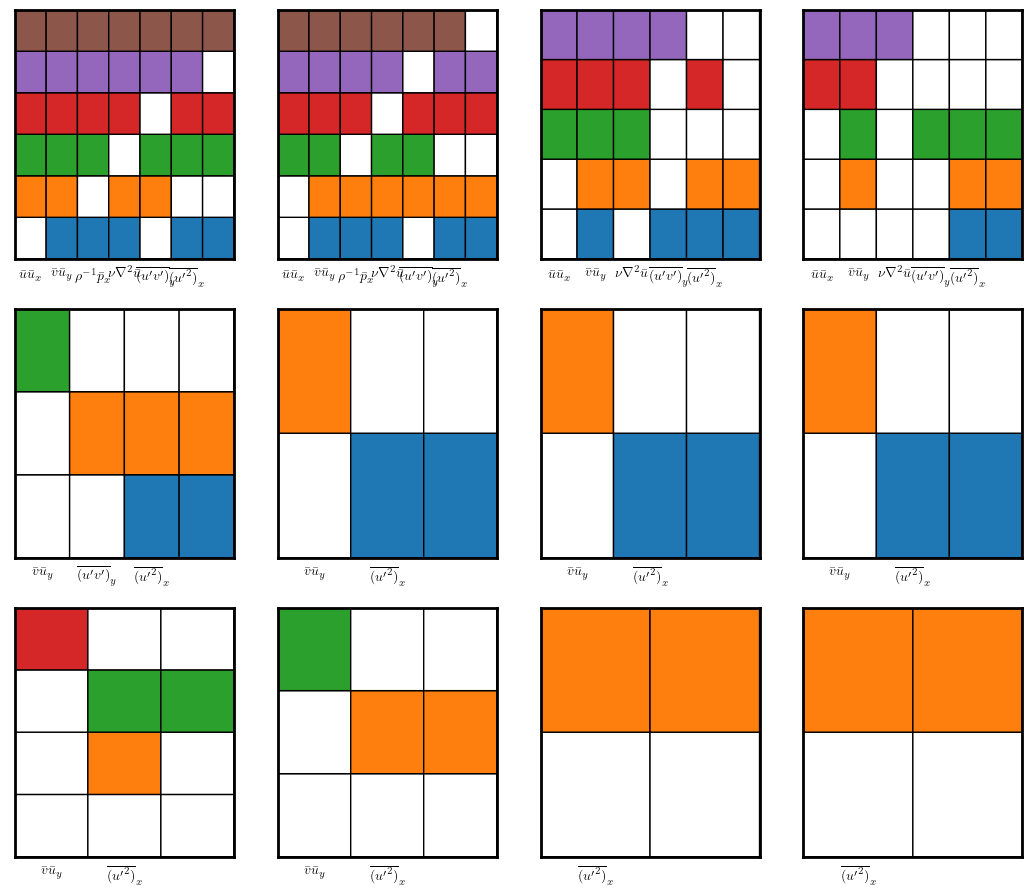

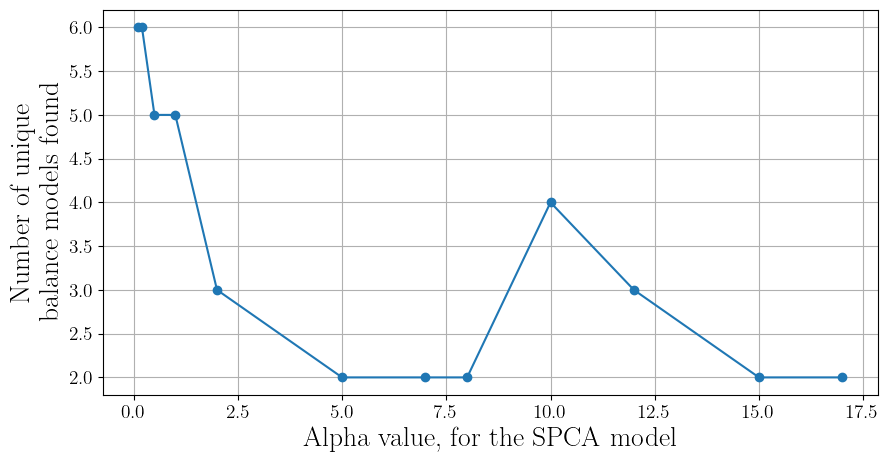

In [122]:
# Initialise a list of the number of dominant balance models found
nmodels_list = []

# Define a list of training set sizes, as fractions of the total dataset
alphas = [0.1, 0.2, 0.5, 1, 2, 5, 7, 8, 10, 12, 15, 17]
np.random.seed(75016)

# Plot all found dominant balance regimes for each initial cluster number
plt.figure(figsize=(13, 11))

for idx, alpha in enumerate(alphas):
    # Get the active terms for the current alpha
    spca_model = sa.get_spca_active_terms(alpha, 6, cluster_idx, features, nfeatures)

    (
        balance_models,
        model_index,
        nmodels,
        gridmap,
        grid_labels,
    ) = sa.get_unique_balance_models(spca_model)

    nmodels_list.append(nmodels)

    plt.subplot(3, 4, idx + 1)
    plt.pcolor(
        gridmap, vmin=-0.5, vmax=cm.N - 0.5, cmap=cm, edgecolors="k", linewidth=1
    )
    plt.gca().set_xticks(np.arange(0.5, len(grid_labels) + 0.5))
    plt.gca().set_xticklabels(grid_labels, fontsize=10)
    plt.gca().set_yticklabels([])

    for axis in ["top", "bottom", "left", "right"]:
        plt.gca().spines[axis].set_linewidth(2)

    plt.gca().tick_params(axis="both", width=0)

plot_dir = os.path.join(plots_dir, f"different_alpha_bal_mods_{n_clusters}.png")
plt.savefig(plot_dir, bbox_inches="tight")

plt.show()

plt.figure(figsize=(10, 5))
plt.plot(alphas, nmodels_list, "o-")
plt.xlabel("Alpha value, for the SPCA model")
plt.ylabel("Number of unique \n balance models found")
plt.grid()

plot_dir = os.path.join(plots_dir, f"different_alpha_nmodels_{n_clusters}.png")
plt.savefig(plot_dir, bbox_inches="tight")

plt.show()

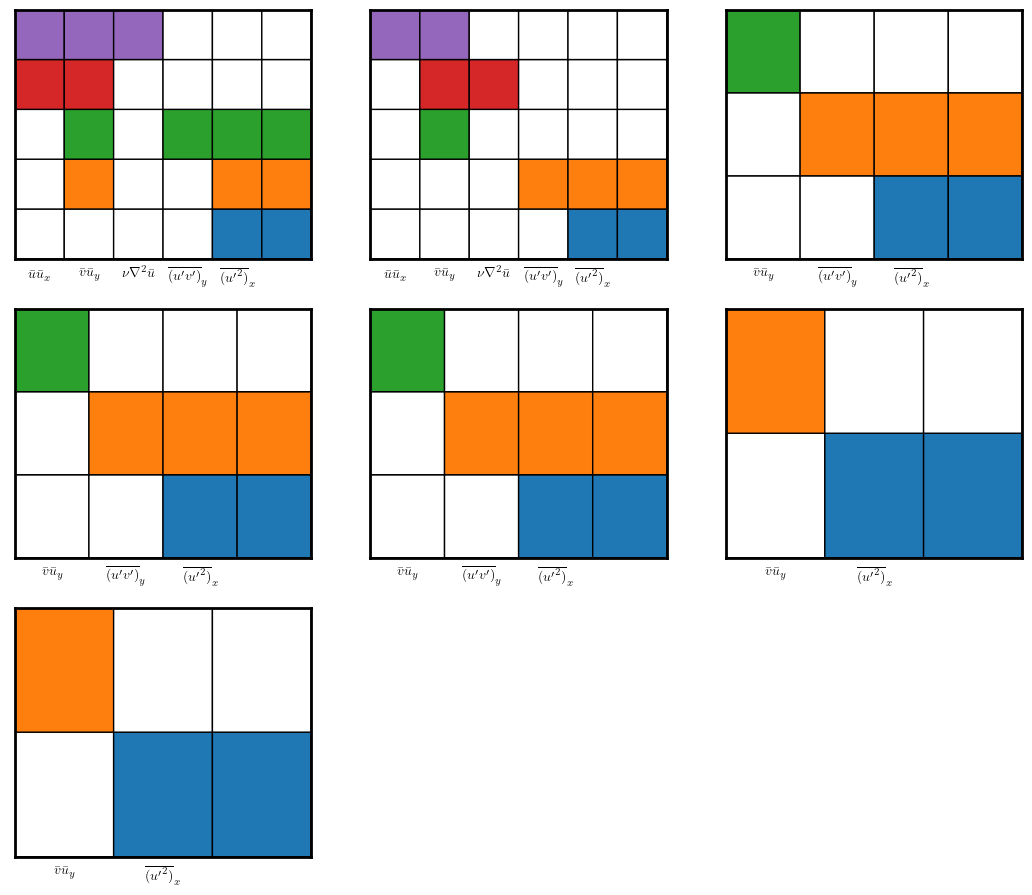

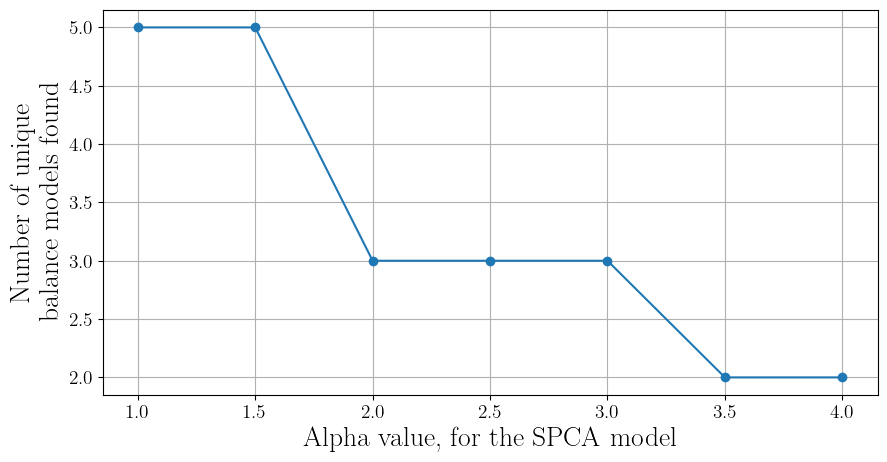

In [123]:
# Initialise a list of the number of dominant balance models found
nmodels_list = []

# Define a list of training set sizes, as fractions of the total dataset
alphas = [1, 1.5, 2, 2.5, 3, 3.5, 4]
np.random.seed(75016)

# Plot all found dominant balance regimes for each initial cluster number
plt.figure(figsize=(13, 11))

for idx, alpha in enumerate(alphas):
    # Get the active terms for the current alpha
    spca_model = sa.get_spca_active_terms(alpha, 6, cluster_idx, features, nfeatures)

    (
        balance_models,
        model_index,
        nmodels,
        gridmap,
        grid_labels,
    ) = sa.get_unique_balance_models(spca_model)

    nmodels_list.append(nmodels)

    plt.subplot(3, 3, idx + 1)
    plt.pcolor(
        gridmap, vmin=-0.5, vmax=cm.N - 0.5, cmap=cm, edgecolors="k", linewidth=1
    )
    plt.gca().set_xticks(np.arange(0.5, len(grid_labels) + 0.5))
    plt.gca().set_xticklabels(grid_labels, fontsize=10)
    plt.gca().set_yticklabels([])

    for axis in ["top", "bottom", "left", "right"]:
        plt.gca().spines[axis].set_linewidth(2)

    plt.gca().tick_params(axis="both", width=0)

plot_dir = os.path.join(plots_dir, f"different_alpha_bal_mods_zoom_{n_clusters}.png")
plt.savefig(plot_dir, bbox_inches="tight")

plt.show()

plt.figure(figsize=(10, 5))
plt.plot(alphas, nmodels_list, "o-")
plt.xlabel("Alpha value, for the SPCA model")
plt.ylabel("Number of unique \n balance models found")
plt.grid()

plot_dir = os.path.join(plots_dir, f"different_alpha_nmodels_zoom_{n_clusters}.png")
plt.savefig(plot_dir, bbox_inches="tight")

plt.show()

Thus a good value for $\alpha$ could be ...

[[0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 1. 0. 0. 0. 1. 0.]]
(8, 7)
['$u_{t}$', '$u u_{x}$', '$v u_{y}$', '$p_{x}$', '$\\nabla^2 u$', '$[T(C)]_{1}$', '$[T(C)]_{2}$']
7


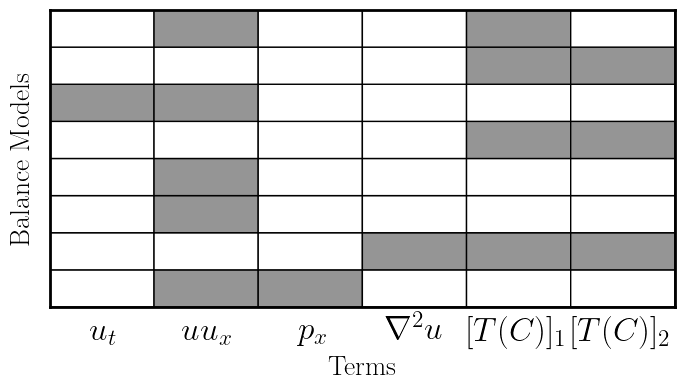

In [131]:
# Set the alpha regularization term its optimal value
alpha = 1.5

# Initialize the sparse PCA model
spca_model = np.zeros((n_clusters, features.shape[1]))

for i in range(n_clusters):
    feature_idx = np.where(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(n_components=1, alpha=alpha, random_state=seed)
    spca.fit(cluster_features)

    active_terms = np.where(spca.components_[0] != 0)[0]
    if len(active_terms) > 0:
        spca_model[i, active_terms] = 1  # Set the active terms to 1

pf.plot_balance_models(
    spca_model,
    color=False,
    labels=labels,
    path=f"EIT/active_terms_{n_clusters}_{alpha}.png",
)

## 5. Get the unique balance models

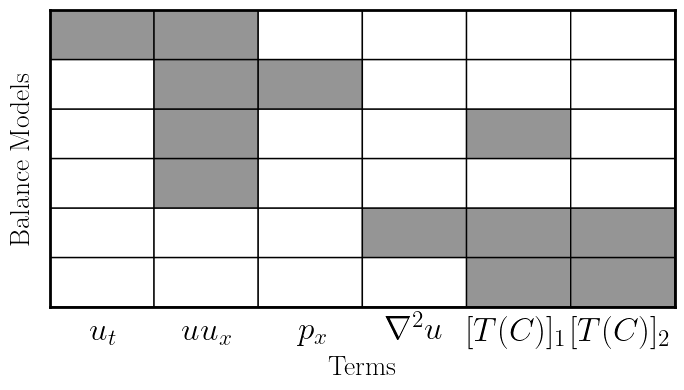

In [125]:
nfeatures = features.shape[1]

# Convert the spca_model array to a dataframe
spca_temp = pd.DataFrame(spca_model.copy())

# Group the balance models by the values of all columns
grouped_models = spca_temp.groupby(np.arange(nfeatures).tolist())
grouped_models = grouped_models.groups.items()

# Combine balance models that have identical active terms
# For each balance model, the spca models that have the same active terms
# are given the same index
balance_models = pd.DataFrame(np.zeros((len(grouped_models), nfeatures)))
model_idx = np.zeros(len(spca_model), dtype=int)

for i, b_model in enumerate(grouped_models):
    idx = b_model[1].to_list()
    model_idx[idx] = i
    balance_models.loc[i] = spca_temp.loc[idx[0]].to_numpy()

# Convert the balance models to a numpy array
balance_models = balance_models.drop_duplicates(keep="first")
balance_models = balance_models.to_numpy()
nmodels = balance_models.shape[0]


# Plot a grid of the active terms
pf.plot_balance_models(
    balance_models,
    color=False,
    labels=labels,
    path=f"EIT/final_active_terms_{n_clusters}_{alpha}.png",
)

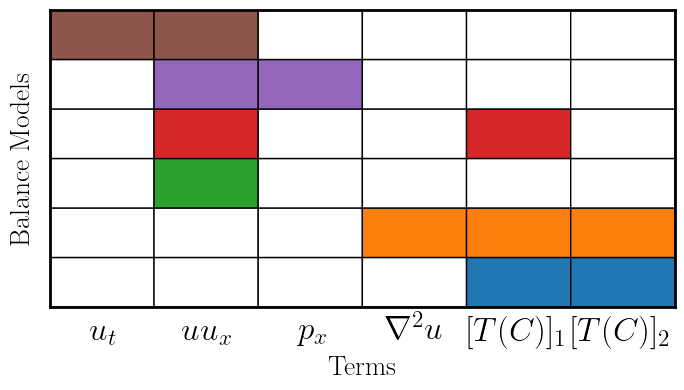

In [126]:
# Plot the balance models in a grid
pf.plot_balance_models(
    balance_models,
    color=True,
    labels=labels,
    path=f"EIT/balance_models_{n_clusters}_{alpha}.png",
)

In [127]:
# Assign the new cluster indices
balance_idx = np.array([model_idx[i] for i in cluster_idx])

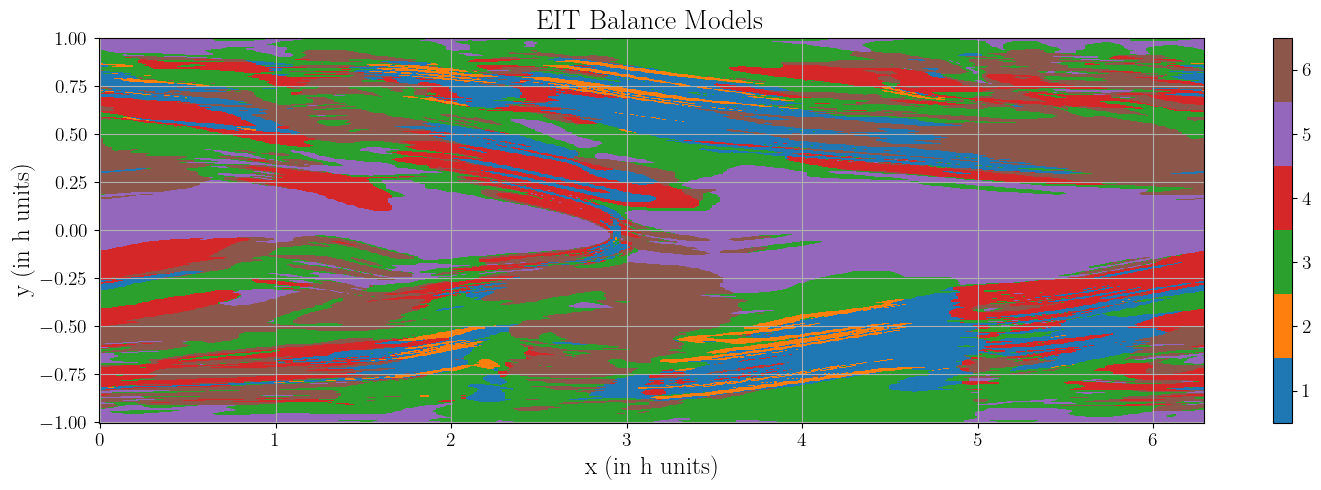

In [128]:
# Plot the clusters in space
balancemap = balance_idx.reshape((ny, nx))
pf.plot_clusters_eit(
    balancemap,
    Lx,
    nx,
    Ly,
    ny,
    nmodels,
    path=f"EIT/spca_clustering_space_{n_clusters}_{alpha}.png",
)

## 6. Use GMM's probabilistic nature to get the uncertainty of the results


In the above codes were lines to calculate the uncertainty for each point of belonging in one cluster. For each point, the probability is calculated as the sum of probability of belonging to each cluster that make up the balance model.

In [129]:
# FOR UNCERTAINTIES
# Sum the cluster probabilities for the balance model that the point belongs to
# FOR UNCERTAINTIES
balance_probs = np.zeros((len(cluster_idx)))
for i in range(len(cluster_idx)):
    idx = np.where(model_idx == balance_idx[i])[0]
    balance_probs[i] = 1 - np.sum(cluster_probs[i, idx])

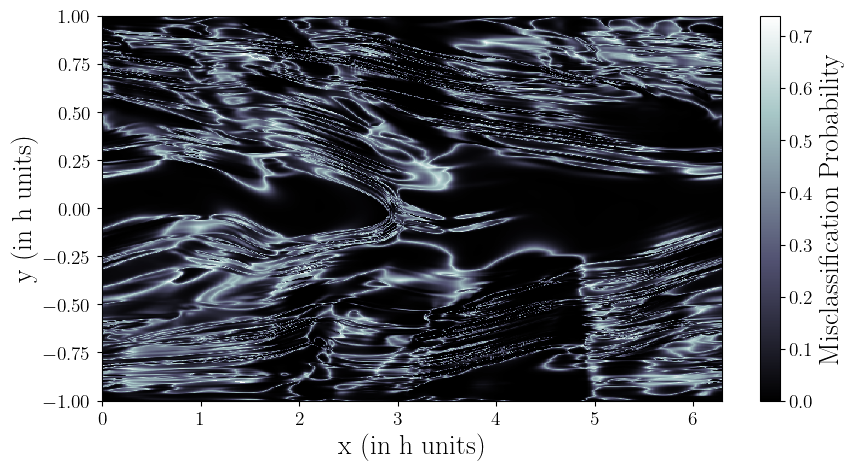

In [130]:
# Plot the balance model probabilities
balance_prob_map = balance_probs.reshape((ny, nx))

plt.figure(figsize=(10, 5))

plt.pcolormesh(X, Y, balance_prob_map, cmap="bone")
plt.xlabel("x (in h units)")
plt.ylabel("y (in h units)")
cbar = plt.colorbar()
cbar.set_label("Misclassification Probability")